In [1]:
import urllib3
import urllib.request
import numpy as np
from bs4 import BeautifulSoup #https://stackoverflow.com/questions/11023530/python-to-list-http-files-and-directories
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import datasets, linear_model
from sklearn import metrics

column_names = {'local_relative_humidity': 30, 'local_relative_humidity_uncertainty': 32}    
base_url = 'https://atmos.nmsu.edu/PDS/data/mslrem_1001/DATA/'
sol_epoch_starts = np.array([1, 90, 180, 270, 360, 450, 584, 708, 805, 939, 1063, 1160, 1294, 1418, 1515, 1649, 1773, 1870, 2004, 2128, 2225, 2359])
# num_epochs = sol_epoch_starts.size - 1
num_epochs = 1

def listFD(url, ext=''):
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

def get_epoch_name(index):
    string1 = str(sol_epoch_starts[index]) 
    string2 = str(sol_epoch_starts[index+1] - 1)
    string1 = '0' * (5 - len(string1)) + string1    
    string2 = '0' * (5 - len(string2)) + string2
    entire_string = 'SOL_' + string1 + '_' + string2
    return entire_string  

def get_sol_name(sol_num):
    string = str(sol_num)
    string = 'SOL' + '0' * (5 - len(string)) + string
    return string

http = urllib3.PoolManager()
r2_temp1s = []
temp1_accuracies = []
r2_temp2s = []
temp2_accuracies = []
r2_ambtemps = []
ambtemp_accuracies = []
r2_alltemps = []
alltemps_accuracies = []
r2_pressures = []
press_accuracies = []
r2_alls = []
all_accuracies = []

lm = linear_model.LinearRegression() 

In [4]:
#1-89 Sols
sol_epoch_starts = np.array([1, 90, 180, 270, 360, 450, 584, 708, 805, 939, 1063, 1160, 1294, 1418, 1515, 1649, 1773, 1870, 2004, 2128, 2225, 2359])

data_all = []
for epoch_index in range(num_epochs):                            
    epoch_file_name = get_epoch_name(epoch_index)
    for sol_number in range(sol_epoch_starts[epoch_index], sol_epoch_starts[epoch_index+1]):
        sol_file_name = get_sol_name(sol_number)
        entire_url = base_url + epoch_file_name + '/' + sol_file_name
        entire_list = listFD(entire_url)
        for file_name in entire_list:
            if ('RMD' in file_name) and ('TAB' in file_name):
                final_file_name = file_name
                r = http.request('GET', final_file_name)
                data = r.data.decode('utf-8')
                data = data.split('\n')
                data_all += [line.split(',') for line in data]
                break

df = pd.DataFrame(data_all)
df = df[[0, 11, 12, 13, 14, 15, 16, 30, 31, 32, 37, 38, 39]]
df = df.replace('    UNK', np.nan)
df = df.dropna()
df[[11,13,15,30,37]] = df[[11,13,15,30,37]].apply(pd.to_numeric)

name_dict = {11:'boom1_local_air_temperature', 30: 'local_relative_humidity', 13:'boom2_local_air_temperature', 37: 'pressure', 15: 'ambient_temperature'}
new_df = df.rename(name_dict, axis = 1)
rel_humidity = new_df[['local_relative_humidity']].values.reshape(-1,1)

#5-fold cross validation
ground_temp_1 = new_df[['boom1_local_air_temperature']].values.reshape(-1,1) # values converts it into a numpy array
ground_temp_1_train, ground_temp_1_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_1, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_1_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_1, rel_humidity, cv=5)
r2_temp1 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_1, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp1_accuracies.append(accuracy)
r2_temp1s.append(r2_temp1)


ground_temp_2 = new_df[['boom2_local_air_temperature']].values.reshape(-1,1) 
ground_temp_2_train, ground_temp_2_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_2, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_2_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_2, rel_humidity, cv=5)
r2_temp2 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_2, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp2_accuracies.append(accuracy)
r2_temp2s.append(r2_temp2)


amb_temp = new_df[['ambient_temperature']].values.reshape(-1,1)
amb_temp_train, amb_temp_test, rel_hum_train, rel_hum_test = train_test_split(amb_temp, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(amb_temp_train, rel_hum_train)
scores = cross_val_score(model, amb_temp, rel_humidity, cv=5)
r2_amb_temp = np.average(scores)
predictions = cross_val_predict(model, amb_temp, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
ambtemp_accuracies.append(accuracy)
r2_ambtemps.append(r2_amb_temp)

press = new_df[['pressure']].values.reshape(-1,1) 
press_train, press_test, rel_hum_train, rel_hum_test = train_test_split(press, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(press_train, rel_hum_train)
scores = cross_val_score(model, press, rel_humidity, cv=5)
r2_press = np.average(scores)
predictions = cross_val_predict(model, press, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
press_accuracies.append(accuracy)
r2_pressures.append(r2_press)

all_temp_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature']].values
all_temp_x_train, all_temp_x_test, rel_hum_train, rel_hum_test = train_test_split(all_temp_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_temp_x_train, rel_hum_train)
scores = cross_val_score(model, all_temp_x, rel_humidity, cv=5)
r2_all_temps = np.average(scores)
predictions = cross_val_predict(model, all_temp_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
alltemps_accuracies.append(accuracy)
r2_alltemps.append(r2_all_temps)


all_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature', 'pressure']].values
all_train, all_test, rel_hum_train, rel_hum_test = train_test_split(all_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_train, rel_hum_train)
scores = cross_val_score(model, all_x, rel_humidity, cv=5)
r2_all = np.average(scores)
predictions = cross_val_predict(model, all_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
all_accuracies.append(accuracy)
r2_alls.append(r2_all)


print("1-89 Sols")
print("R^2 for Boom 1 Temperature:", r2_temp1)               
print("R^2 for Boom 2 Temperature:", r2_temp2)
print("R^2 for Ambient Temperature:", r2_amb_temp)
print("R^2 for Pressure:", r2_press)
print("R^2 for All Temperatures:", r2_all_temps)
print("R^2 for All:", r2_all)

1-89 Sols
R^2 for Boom 1 Temperature: 0.608591468035422
R^2 for Boom 2 Temperature: 0.7253220904412425
R^2 for Ambient Temperature: 0.579687781461556
R^2 for Pressure: -0.16808231688484815
R^2 for All Temperatures: 0.732016063124501
R^2 for All: 0.7349206545334027


[0.8245994713967881, 0.824700181204222, 0.8247765674892203]


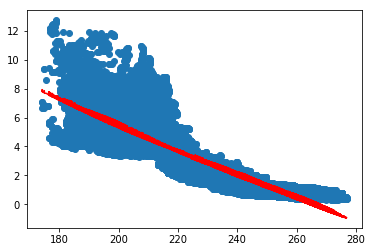

In [27]:
from sklearn.model_selection import KFold # import KFold
all_temp_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature']].values

X = all_temp_x
y = rel_humidity
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
first_predictor = []
first_x = []
first_y = []
for i, (train, test) in enumerate(kfold.split(X, y)):
    
    model = linreg.fit(X[train,:], y[train,:])
    score = linreg.score(X[test,:], y[test,:])
    all_temp_test = X[test,:]
#     print(len(predictor))
    scores.append(score)
    predictor = linreg.predict(all_temp_test)
    if i == 0:

        for triplet in X[test,:]:
            first_x.append(np.average(triplet))
        for triplet in y[test,:]:
            first_y.append(np.average(triplet))
#         for item in X[test,:]:
#             first_x.append(item[0])
#         for item in y[test,:]:
#             first_y.append(item[0])
#         for item in predictor:
#             first_predictor.append(item[0])
        plt.plot(first_x, first_y, linestyle = '', marker = 'o')
        
        plt.plot(first_x, predictor, color = 'red')
print(scores)


Cross-validated scores: [0.82481704 0.82375639 0.82485362 0.82448464 0.8249257 ]
Cross-Predicted Accuracy: 0.8245697062926831


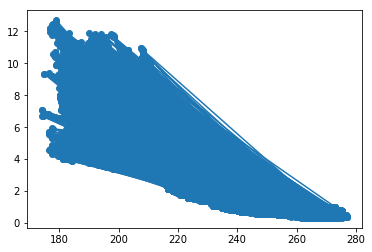

In [68]:
# fit a model

lm = linear_model.LinearRegression()
model = lm.fit(all_temp_train, rel_hum_train)
# predictions = lm.predict(all_temp_test)
from sklearn.model_selection import KFold # import KFold
X = all_temp_x
y = rel_humidity
# kf = KFold(n_splits=2) # Define the split - into 2 folds 
# kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator

# Perform 5-fold cross validation
scores = cross_val_score(model, all_temp_test, rel_hum_test, cv=5)
print('Cross-validated scores:', scores)
# Make cross validated predictions
first_x = []
for triplet in all_temp_test:
    first_x.append(np.average(triplet))
predictions = cross_val_predict(model, all_temp_test, rel_hum_test, cv=5)
plt.plot(first_x, rel_hum_test, marker = 'o', linestyle = '')
# plt.plot(press_test, rel_hum_test, linestyle='', marker = 'o', markersize=0.7, color = 'm')
# plt.plot(press_test, hum_pred, color='red', linewidth=2)
accuracy = metrics.r2_score(rel_hum_test, predictions)
print('Cross-Predicted Accuracy:', accuracy)

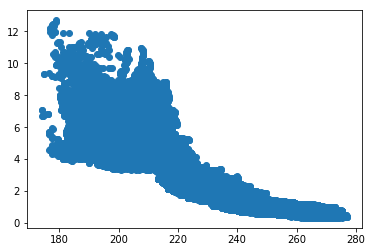

In [69]:
plt.plot(first_x, rel_hum_test, marker = 'o', linestyle = '')

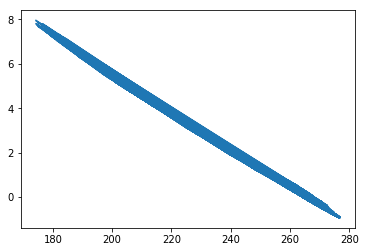

In [70]:
plt.plot(first_x, predictions)

Cross-validated scores: [0.83215305 0.86569968 0.77687041 0.80244789 0.80041007]
Cross-Predicted Accuracy: 0.8150924530496848


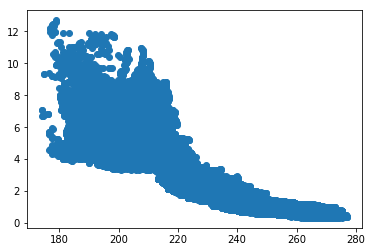

In [71]:

lm = linear_model.LinearRegression()
model = lm.fit(all_temp_train, rel_hum_train)
# predictions = lm.predict(all_temp_test)
from sklearn.model_selection import KFold # import KFold
X = all_temp_x
y = rel_humidity
# kf = KFold(n_splits=2) # Define the split - into 2 folds 
# kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator

# Perform 5-fold cross validation
scores = cross_val_score(model, all_temp_x, rel_humidity, cv=5)
print('Cross-validated scores:', scores)
# Make cross validated predictions
first_x = []
for triplet in all_temp_test:
    first_x.append(np.average(triplet))
predictions = cross_val_predict(model, all_temp_x, rel_humidity, cv=5)
# plt.plot(first_x, rel_hum_test, marker = 'o', linestyle = '')
# plt.plot(press_test, rel_hum_test, linestyle='', marker = 'o', markersize=0.7, color = 'm')
# plt.plot(press_test, hum_pred, color='red', linewidth=2)
accuracy = metrics.r2_score(rel_humidity, predictions)
print('Cross-Predicted Accuracy:', accuracy)

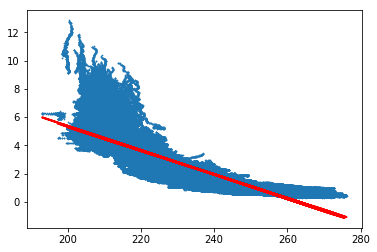

In [78]:

lm = linear_model.LinearRegression()
model = lm.fit(all_temp_train, rel_hum_train)

# Perform 5-fold cross validation
amb_temp = new_df[['ambient_temperature']].values.reshape(-1,1)
scores = cross_val_score(model, amb_temp, rel_humidity, cv=5)
predictions = cross_val_predict(model, amb_temp, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
plt.plot(amb_temp, rel_humidity, marker = 'o', markersize=0.7, linestyle = '')
plt.plot(amb_temp, predictions, color = 'red', linewidth=2)

In [79]:
scores

array([0.80341409, 0.85366128, 0.8057332 , 0.77952241, 0.78738279])

In [80]:
all_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature', 'pressure']].values
scores = cross_val_score(model, all_x, rel_humidity, cv=5)
predictions = cross_val_predict(model, all_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
all_accuracies.append(accuracy)
r2_alls.append(np.average(scores))

NameError: name 'all_accuracies' is not defined